# Gaussian processes in Tensorflow

In [1]:
import tensorflow as tf
tf.__version__

'1.8.0'

Geostatistical datasets are often a set of measurements with locations. Nearby measurements covary a lot. Distant measurements are nearly independent.

Let's simulate this:

  * Define $N$ locations $x$ by drawing uniformly at random from a square area.
  * Create $N\times N$ distance matrix $D$ (euclidean distance between locations).
  * Define a covariance function: $c(d; r, s, n) = s \cdot \exp(-(d/r)^2) + n \cdot \delta_d$, where $d$ is distance, and $(r, s, n)$ correspond to range/sill/nugget on a variogram. (I think the convention varies between  calling either $s+n$ or $s$ the sill.) Also, $\delta_d$ is 1 when $d$ is 0, and 0 otherwise.
  * Use the covariance function to map $D$ elementwise to a covariance matrix $C$.
  * Draw $u \sim \textrm{Normal}(\beta_1 \cdot \mathbb{1}, C)$ to obtain values, where $\beta_1$ is the (scalar) mean value of a single draw, and $\mathbb{1}$ is a vector of $N$ ones.

This is implemented as `simulate_gp` below. The range is called `vrange` to avoid conflicting with Python's `range`.

The data consists of locations `x` (or equivalently, the distance matrix `D`) and measurements `u`.

In [2]:
import numpy as np
from scipy.spatial.distance import cdist
np.set_printoptions(precision=2, threshold=50)

def simulate_gp(N, vrange, sill, nugget, offset):

    # Sample N locations from square with corners at [±10, ±10].
    x = np.random.uniform(-10.0, 10.0, [N, 2]) 

    # Compute distance matrix for sampled locations.
    D = cdist(x, x)

    # Compute corresponding covariance matrix.
    C = sill * np.exp(-np.square(D/vrange)) + nugget * np.eye(N)

    # The mean is just a vector where every entry is the offset.
    m = np.zeros([N]) + offset

    # Simulate geospatial measurements by sampling using covariance matrix
    u = np.random.multivariate_normal(m, C)

    return x, D, C, m, u

Now we call `simulate_gp` and plot the result. (You may have to run this twice to get the plot to show up.)

Locations
[[ 0.83  9.5 ]
 [-6.51  0.99]
 [ 2.84  6.14]
 ...
 [-4.99  0.45]
 [-3.49  2.24]
 [ 5.49 -0.34]]
Distance matrix
[[ 0.   11.24  3.92 ... 10.76  8.45 10.89]
 [11.24  0.   10.68 ...  1.61  3.26 12.07]
 [ 3.92 10.68  0.   ...  9.68  7.44  7.  ]
 ...
 [10.76  1.61  9.68 ...  0.    2.33 10.51]
 [ 8.45  3.26  7.44 ...  2.33  0.    9.34]
 [10.89 12.07  7.   ... 10.51  9.34  0.  ]]
Covariance matrix
[[4.   0.01 1.08 ... 0.02 0.11 0.02]
 [0.01 4.   0.02 ... 1.8  1.31 0.01]
 [1.08 0.02 4.   ... 0.05 0.22 0.28]
 ...
 [0.02 1.8  0.05 ... 4.   1.61 0.02]
 [0.11 1.31 0.22 ... 1.61 4.   0.06]
 [0.02 0.01 0.28 ... 0.02 0.06 4.  ]]
Simulated measurements
[ 2.78 -0.64 -0.56 ... -0.27  2.02  2.  ]


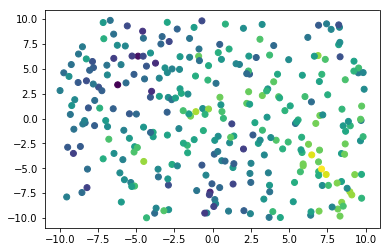

In [9]:
x, D, C, m, u = simulate_gp(
    N = 300,
    vrange = 5.0,
    sill = 2.0,
    nugget = 2.0,
    offset = 1.0)

print("Locations")
print(x)

print("Distance matrix")
print(D)

print("Covariance matrix")
print(C)

print("Simulated measurements")
print(u)

import matplotlib.pyplot as pp

pp.scatter(x[:, 0], x[:, 1], c=u)
pp.show()

Now we make a function `infer_gp` to infer the gaussian process parameters (range, sill, nugget, offset) using maximum likelihood. We implement the same graph in Tensorflow as we did in NumPy, and tack on the negative log PDF of a multivariate normal distribution at the end, which we minimize. That is, we minimize:
$$-\log p(u \mid m, C) = \frac{1}{2}\bigg[\log\,\big|\, 2\pi C\,\big| + (u-m)^T C^{-1} (u-m) \bigg],$$
where $m = \beta_1 \cdot \mathbb{1}$.

The function has two arguments:
  * `inputs` is a list of `numpy` arrays:
      * Distance matrix `D` (shape: [N, N])
      * Measurements `u` (shape: [N])
  *  `parameters` is a list of tensors for range, sill, nugget, and offset. Each tensor can be a `tf.Variables` (if it is to be inferred) or a constant (if it's a given).

In [10]:
def infer_gp(inputs, parameters):

    D, u = inputs
    vrange, sill, nugget, offset = parameters
    
    # Construct covariance; boost diagonal by 1e-6 for numerical stability.
    covariance = sill * tf.exp(-tf.square(tf.constant(D)/vrange)) \
               + (nugget + 1e-6) * tf.eye(D.shape[0], dtype=tf.float64)

    # Log likelihood is the PDF of a multivariate gaussian.
    u_adj = tf.constant(u) - offset
    logdet = tf.linalg.logdet(2 * np.pi * covariance)
    quad = tf.matmul(tf.expand_dims(u_adj, 0), tf.matrix_solve(covariance, tf.expand_dims(u_adj, -1)))[0, 0]
    ll = -0.5 * (logdet + quad)

    # Infer using an adaptive gradient descent optimizer.
    train = tf.train.AdamOptimizer(1e-2).minimize(-ll)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(20):
            for j in range(100):
                sess.run(train)
            print('[ll %7.2f] [range %4.2f] [sill %4.2f] [nugget %4.2f] [offset %4.2f]' % 
                  tuple(sess.run([ll, vrange, sill, nugget, offset])))
            
        return sess.run([vrange, sill, nugget, offset])

Here we make a `tf.Variable` for each parameter, using a log as the underlying representation if the parameter is positive-only.

In [11]:
# Define parameters using tf.Variable.
log_vrange = tf.Variable(0.0, dtype=tf.float64)
log_sill = tf.Variable(0.0, dtype=tf.float64)
log_nugget = tf.Variable(0.0, dtype=tf.float64)

vrange = tf.exp(log_vrange)
sill = tf.exp(log_sill)
nugget = tf.exp(log_nugget)
offset = tf.Variable(0.0, dtype=tf.float64)

vrange_val, sill_val, nugget_val, offset_val = infer_gp([D, u], [vrange, sill, nugget, offset])

[ll -552.48] [range 2.25] [sill 1.48] [nugget 1.66] [offset 0.63]
[ll -537.88] [range 3.71] [sill 1.36] [nugget 1.68] [offset 0.84]
[ll -536.83] [range 4.20] [sill 1.38] [nugget 1.70] [offset 0.96]
[ll -536.62] [range 4.28] [sill 1.42] [nugget 1.71] [offset 1.05]
[ll -536.51] [range 4.28] [sill 1.43] [nugget 1.71] [offset 1.12]
[ll -536.45] [range 4.27] [sill 1.42] [nugget 1.71] [offset 1.18]
[ll -536.42] [range 4.26] [sill 1.41] [nugget 1.71] [offset 1.23]
[ll -536.41] [range 4.25] [sill 1.40] [nugget 1.71] [offset 1.26]
[ll -536.40] [range 4.25] [sill 1.40] [nugget 1.71] [offset 1.27]
[ll -536.40] [range 4.24] [sill 1.40] [nugget 1.71] [offset 1.29]
[ll -536.40] [range 4.24] [sill 1.40] [nugget 1.71] [offset 1.29]
[ll -536.40] [range 4.24] [sill 1.40] [nugget 1.71] [offset 1.30]
[ll -536.40] [range 4.24] [sill 1.40] [nugget 1.71] [offset 1.30]
[ll -536.40] [range 4.24] [sill 1.40] [nugget 1.71] [offset 1.30]
[ll -536.40] [range 4.24] [sill 1.40] [nugget 1.71] [offset 1.30]
[ll -536.4

We can do better inference by integrating over all possibilities for $\beta_1$.  (Integrating over range, sill, and nugget, which are parameters in $C$, is hard; but integrating over parameters in $m$ is relatively easy.) This corresponds to the following generative model.

First, draw $\beta_1$ from a normal distribution:

$$\beta_1 \sim \mathcal{N}(0, 100).$$

The variance should be large enough that the distribution assigns reasonably large probabilities to any plausible value for $\beta_1$.

Next, draw $u$ from a multivariate normal distribution, as we've been doing all along:

$$u \mid \beta_1 \sim \mathcal{N}(\beta_1 \cdot \mathbb{1}, C).$$

From this we can derive a distribution for $u$ by marginalizing (integrating) over $\beta_1$. That is, we can compute:

$$p(u) = \int_{-\infty}^{\infty} p(u\mid\beta_1) \, p(\beta_1) \, d\beta_1.$$

We rely on the abstract fact that if $X_1 \sim \mathcal{N}(\mu_1, \Sigma_1)$ and $X_2 \mid X_1 \sim \mathcal{N}(\mu_2, \Sigma_2)$, then $X_2 \sim \mathcal{N}(\mu_1, \Sigma_1 + \Sigma_2)$.  ($X_1$ and $X_2$ are vectors equal in length.) To apply this, we note that since $\beta_1 \sim \mathcal{N}(0, 100)$, then $\beta_1 \cdot \mathbb{1} \sim \mathcal{N}(0, 100 \cdot \mathbb{1}\mathbb{1}^T)$, where $\mathbb{1}\mathbb{1}^T$ is a matrix of all ones. From this it follows that

$$u \sim \mathcal{N}(0, A)$$

where $A = 100 \cdot \mathbb{1}\mathbb{1}^T + C.$ The function below implements inference with this model, where the offset is marginalized out.

In [6]:
def infer_gp_marginalize_over_offset(inputs, parameters, offset_prior):

    D, u = inputs
    vrange, sill, nugget = parameters

    # Construct covariance; boost diagonal by 1e-6 for numerical stability.
    covariance = sill * tf.exp(-tf.square(tf.constant(D)/vrange)) \
               + (nugget + 1e-6) * tf.eye(D.shape[0], dtype=tf.float64) \
               + offset_prior
    
    # Log likelihood is the PDF of a multivariate gaussian.
    u_adj = tf.constant(u) - offset
    logdet = tf.linalg.logdet(2 * np.pi * covariance)
    quad = tf.matmul(tf.expand_dims(u_adj, 0), tf.matrix_solve(covariance, tf.expand_dims(u_adj, -1)))[0, 0]
    ll = -0.5 * (logdet + quad)

    # Infer using an adaptive gradient descent optimizer.
    train = tf.train.AdamOptimizer(1e-2).minimize(-ll)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(20):
            for j in range(100):
                sess.run(train)
            print('[ll %7.2f] [range %4.2f] [sill %4.2f] [nugget %4.2f]' % tuple(sess.run([ll, vrange, sill, nugget])))
            
        return sess.run([vrange, sill, nugget])

When we run this, we don't get an estimate for the offset, but the other estimates are often improved. Bear in mind that we can actually solve for the posterior distribution of the offset if we want to.

In [7]:
# Define parameters using tf.Variable.
log_vrange = tf.Variable(0.0, dtype=tf.float64)
log_sill = tf.Variable(0.0, dtype=tf.float64)
log_nugget = tf.Variable(0.0, dtype=tf.float64)

vrange = tf.exp(log_vrange)
sill = tf.exp(log_sill)
nugget = tf.exp(log_nugget)

offset_prior = 100.0

vrange_val, sill_val, nugget_val = infer_gp_marginalize_over_offset([D, u], [vrange, sill, nugget], offset_prior)

[ll -541.34] [range 3.02] [sill 0.96] [nugget 1.69]
[ll -537.97] [range 4.51] [sill 1.13] [nugget 1.73]
[ll -537.93] [range 4.65] [sill 1.25] [nugget 1.73]
[ll -537.93] [range 4.67] [sill 1.27] [nugget 1.73]
[ll -537.93] [range 4.67] [sill 1.27] [nugget 1.73]
[ll -537.93] [range 4.67] [sill 1.27] [nugget 1.73]
[ll -537.93] [range 4.67] [sill 1.27] [nugget 1.73]
[ll -537.93] [range 4.67] [sill 1.27] [nugget 1.73]
[ll -537.93] [range 4.67] [sill 1.27] [nugget 1.73]
[ll -537.93] [range 4.67] [sill 1.27] [nugget 1.73]
[ll -537.93] [range 4.67] [sill 1.27] [nugget 1.73]
[ll -537.93] [range 4.67] [sill 1.27] [nugget 1.73]
[ll -537.93] [range 4.67] [sill 1.27] [nugget 1.73]
[ll -537.93] [range 4.67] [sill 1.27] [nugget 1.73]
[ll -537.93] [range 4.67] [sill 1.27] [nugget 1.73]
[ll -537.93] [range 4.67] [sill 1.27] [nugget 1.73]
[ll -537.93] [range 4.67] [sill 1.27] [nugget 1.73]
[ll -537.93] [range 4.67] [sill 1.27] [nugget 1.73]
[ll -537.93] [range 4.67] [sill 1.27] [nugget 1.73]
[ll -537.93]

Interpolation takes values at $N_1$ locations, and gives means and variances for $N_2$ locations. Formally, interpolation takes

  * input locations $x_1$, an $N_1 \times 2$ matrix,
  * input values $u_1$, a vector of $N_1$ elements,
  * output locations $x_2$, an $N_2 \times 2$ matrix.

and gives a distribution for output values $u_2$, a vector of $N_2$ elements. For notational convenience, define

$$x = \begin{bmatrix}x_1\\x_2\end{bmatrix} \textrm{ and } u = \begin{bmatrix}u_1\\u_2\end{bmatrix}.$$

The model remains the same as before, so $u \sim \mathcal{N}(0, A)$, where $A$ is constructed from a distance matrix of all locations $x$ as before. For clarity, let's expand $u$ and $A$:

$$\begin{bmatrix}u_1\\u_2\end{bmatrix} \sim \mathcal{N}\bigg(0, \begin{bmatrix}A_{11} & A_{12}\\A_{21} & A_{22}\end{bmatrix}\bigg).$$

Interpolation consists of getting a distribution for $u_2$ given $u_1$. This is a textbook thing to do with a multivariate normal distribution, and the solution is:

$$u_2 \mid u_1 \sim \mathcal{N}(A_{21}A_{11}^{-1}u_1,\ A_{22} - A_{21}A_{11}^{-1}A_{12}).$$

Bear in mind, if we just want  the marginal variance of each element in $u_2$, we only need to compute the diagonal entries of $A_{22} - A_{21}A_{11}^{-1}A_{12}$.

Refer to [Wikipedia](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions) for more details.



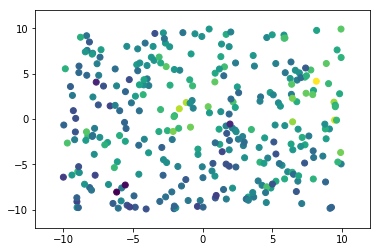

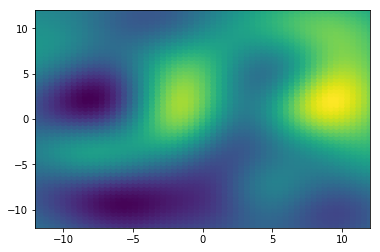

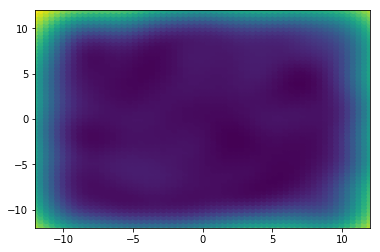

In [8]:
def interpolate_gp(x1, u1, x2, parameter_vals, offset_prior):

    vrange, sill, nugget = parameter_vals

    # Compute distance matrices for sampled locations.
    D11 = cdist(x1, x1)
    D12 = cdist(x1, x2)
    D21 = cdist(x2, x1)
    D22 = cdist(x2, x2)

    # Compute covariance matrices.
    C11 = sill * np.exp(-np.square(D11/vrange)) + nugget * np.eye(len(x1)) + offset_prior
    C12 = sill * np.exp(-np.square(D12/vrange)) + offset_prior # No nugget for off-diagonal entries
    C21 = sill * np.exp(-np.square(D21/vrange)) + offset_prior # No nugget for off-diagonal entries
    C22 = sill * np.exp(-np.square(D22/vrange)) + nugget * np.eye(len(x2)) + offset_prior

    u2_mean = np.matmul(C21, np.linalg.solve(C11, u))
    u2_var = np.diag(C22) -  np.sum(C12 * np.linalg.solve(C11, C12), axis=0)

    return u2_mean, u2_var
                                                                  
MX = 61
MY = 61
M = MX * MY # Number of points to infer.

# Gross code to get mesh locations.
xx, yy = np.meshgrid(np.linspace(-12, 12, MX), np.linspace(-12, 12, MY))
x2 = np.hstack([xx.reshape((M, 1)), yy.reshape((M, 1))])

# Interpolate!
u2_mean, u2_var = interpolate_gp(x, u, x2, [vrange_val, sill_val, nugget_val], offset_prior)                                                                

# Plot old values, new value means, new value variances
for locations, values in [(x, u), (x2, u2_mean), (x2, u2_var)]:
    pp.scatter(locations[:, 0], locations[:, 1], c=values)
    pp.xlim(-12, 12)
    pp.ylim(-12, 12)
    pp.show()